# 6.5 Lab 1: Subset Selection Methods

## 6.5.1 Best Subset Selection

In [103]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd 
import math
import time
import random
import itertools

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.regressionplots import *
from sklearn import datasets, linear_model

In [43]:
Hitters = pd.read_csv('data/Hitters.csv', header=0, na_values='NA')

print list(Hitters) # get the header of this data

print Hitters.shape # get the dimension of this 

Hitters.head() # pull a sample of this dataset

['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat', 'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'League', 'Division', 'PutOuts', 'Assists', 'Errors', 'Salary', 'NewLeague']
(322, 20)


,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


In [44]:
print np.sum(pd.isnull(Hitters['Salary'])) # number of NAs in Salary column'
print Hitters['Salary'].isnull().sum()

Hitters = Hitters.dropna().reset_index(drop=True) # drop the observation with NA values and reindex the obs from 0
Hitters.shape

print Hitters['Salary'].isnull().sum()

59
59
0


In [45]:
y = Hitters.Salary  # the response variable 

"""
take care of the features 
1. change category into dummy variables 
2. Choose (n-1) dummy variable into the feature set: n is the unique values of each categorical variable.
"""

dummies = pd.get_dummies(Hitters[['League', 'Division', 'NewLeague']])
print dummies.head()

X_prep = Hitters.drop (['Salary', 'League', 'Division', 'NewLeague'], axis = 1).astype('float64')
X = pd.concat([X_prep,  dummies[['League_A', 'Division_E', 'NewLeague_A']]], axis=1)

   League_A  League_N  Division_E  Division_W  NewLeague_A  NewLeague_N
0         0         1           0           1            0            1
1         1         0           0           1            1            0
2         0         1           1           0            0            1
3         0         1           1           0            0            1
4         1         0           0           1            1            0


In [66]:
"""
Since in Python there is no well-defined function for best subset selection, 
we will need to define some functions ourselves.
1. Define a function to run on a subset of feature and extract RSS
2. Select the best model (models) for a fix number of features
"""
def getRSS(y, X, feature_list):
    model = sm.OLS(y, X[list(feature_list)]).fit()
    RSS = ((model.predict(X[list(feature_list)]) - y) ** 2).sum()
    return {'Model':model, "RSS":RSS}

def bestModel(y, X, K):
    results = []
    for c in itertools.combinations(X.columns, K):
        results.append(getRSS(y, X, c))     
    model_all =  pd.DataFrame(results)
    
    best_model = model_all.loc[model_all["RSS"].argmin()] ## this could be modified to have the top several models
    return best_model

In [125]:
models = pd.DataFrame(columns=["RSS", "Model"])
for i in range(1,6):  # for illustration purpuse, I just run for 1 - 5 features 
    models.loc[i] = bestModel(y, X, i)
    
print models.loc[2, 'Model'].summary() 
# this summay confirms that the best two variable model contains the variables Hits and CRBI

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     416.7
Date:                Fri, 09 Jun 2017   Prob (F-statistic):           5.80e-82
Time:                        14:26:29   Log-Likelihood:                -1907.6
No. Observations:                 263   AIC:                             3819.
Df Residuals:                     261   BIC:                             3826.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Hits           2.9538      0.261     11.335      0.0

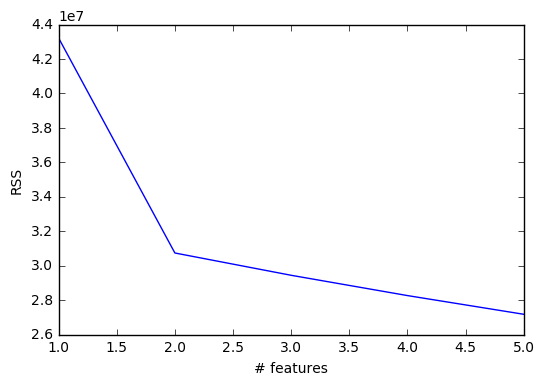

In [126]:
""" this show an example to plot the RSS of best models with different number of parameters"""
plt.figure()
plt.plot(models["RSS"])
plt.xlabel('# features')
plt.ylabel('RSS')
plt.show()

In [127]:
rsquared_adj = models.apply(lambda row: row[1].rsquared_adj, axis=1) # find the adjust R^2, use dir() to identify all available attributes

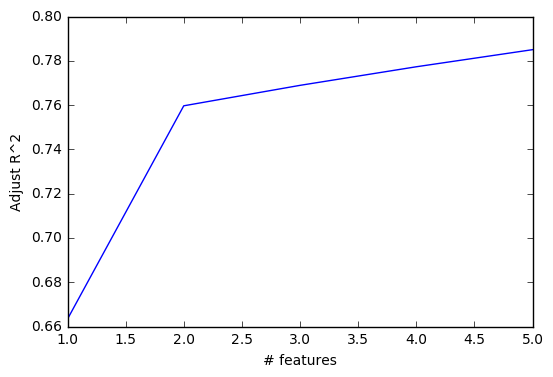

In [128]:
"""
The following graph shows the adj R^2 is still increasing, 
in this case, it is a good idea trying models with more features. 
"""
plt.figure()
plt.plot(rsquared_adj)
plt.xlabel('# features')
plt.ylabel('Adjust R^2')
plt.show()

## 6.5.2 Forward and Backward Stepwise Selection

### Forward Stepwise Selection

In [154]:
"""
We can use the previous user defined function 'def getRSS(y, X, feature_list)' to add 1 feature at a time (start from 0 feature) for forward stepwise selection
or delete 1 feature at a time(start from all the features) for backward stepwise selection. 
"""
def forward_select(y, X, feature_list):
    remaining_predictors = [p for p in X.columns if p not in feature_list]
    results = []
    for p in remaining_predictors:
        results.append(getRSS(y, X, feature_list+[p]))

    models = pd.DataFrame(results)
    best_model = models.loc[models['RSS'].argmin()]
    return best_model  

In [155]:
models2 = pd.DataFrame(columns=["RSS", "Model"])
feature_list = []
for i in range(1,len(X.columns)+1):
    models2.loc[i] = forward_select(y, X, feature_list)
    feature_list = models2.loc[i]["Model"].model.exog_names

In [156]:
"""we can compare the results of best subset selection and the forward selection"""
print models.loc[5, 'Model'].params
print('\n---------------------------------------------')
print('Best 5 variable from best subset selection')
print models2.loc[5, 'Model'].params

AtBat          -1.571703
Hits            7.443980
CRBI            0.684000
PutOuts         0.288405
Division_E    124.035287
dtype: float64

---------------------------------------------
Best 5 variable from best subset selection
Hits            7.443980
CRBI            0.684000
PutOuts         0.288405
AtBat          -1.571703
Division_E    124.035287
dtype: float64


### Backward Stepwise Selection

In [157]:
def backward_select(y, X, feature_list):
    results = []
    for combo in itertools.combinations(feature_list, len(feature_list)-1):
        results.append(getRSS(y, X, combo))

    models = pd.DataFrame(results)
    best_model = models.loc[models['RSS'].argmin()]
    return best_model  

In [158]:
"""
The backward selection starts from all the variables of features
"""
models3 = pd.DataFrame(columns=["RSS", "Model"], index = range(1,len(X.columns)))
feature_list = X.columns

while(len(feature_list) > 1):
    models3.loc[len(feature_list)-1] = backward_select(y, X, feature_list)
    feature_list = models3.loc[len(feature_list)-1]["Model"].model.exog_names

print models3.loc[5, "Model"].params

AtBat     -1.899448
Hits       7.754626
Walks      3.687280
CRuns      0.624463
PutOuts    0.301334
dtype: float64


## 6.5.3 Choosing Among Models Using the Validation Set Approach and Cross-Validation

### In previous sections, we defined the 'best' model based on some statistics (R^2, adj R^2, AIC, BIC, etc) of the training dataset. This may cause 'overfitting' problemm which means the best model on training data can not generalize well to new data. In this section, validation approach will be discussed.

### Validation Set Approach

In [169]:
# Randomly split the data into traning dataset and validation dateset
np.random.seed(seed = 21)
train_index = np.random.choice([True, False], size = len(y), replace = True, p = [0.7, 0.3])
test_index = np.invert(train_index)